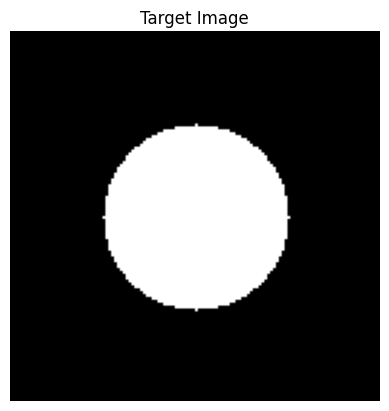

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step: 1000, Current Reward: -87.34


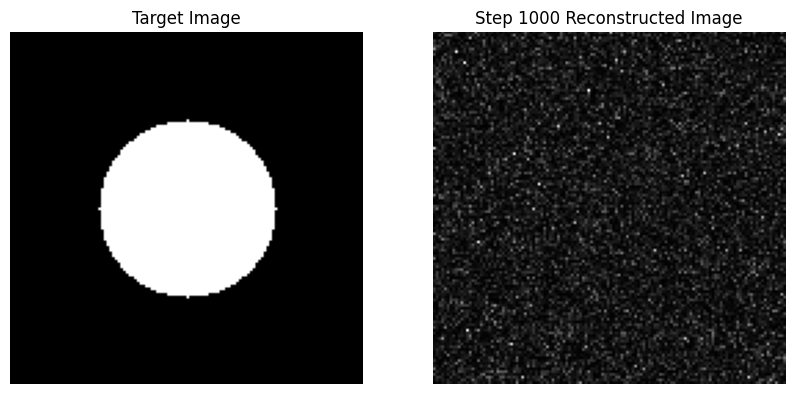

Step: 2000, Current Reward: -87.23


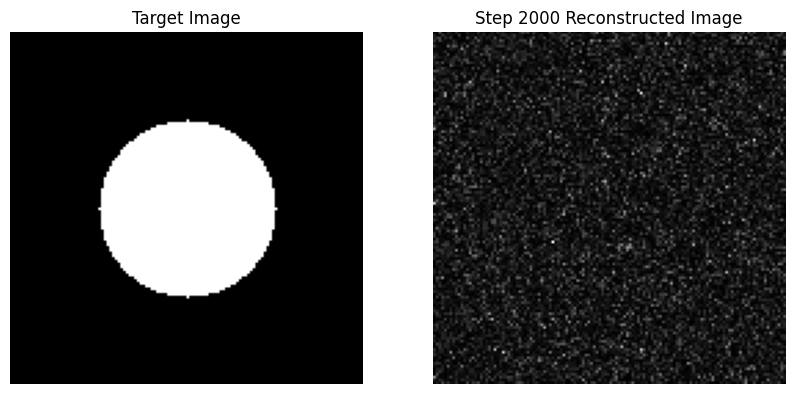

Step: 3000, Current Reward: -87.29


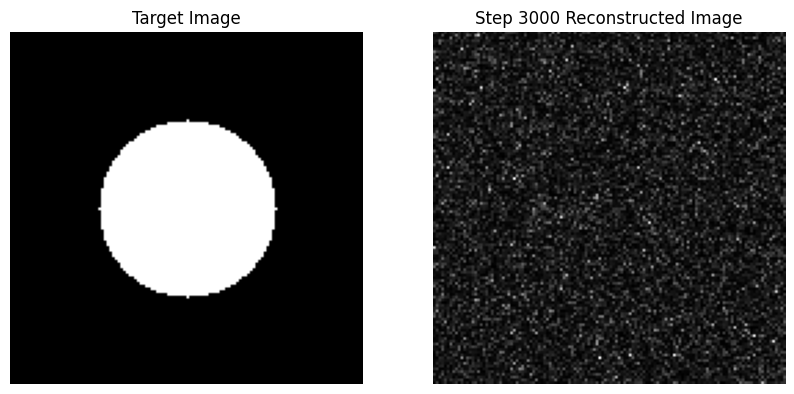

Step: 4000, Current Reward: -87.32


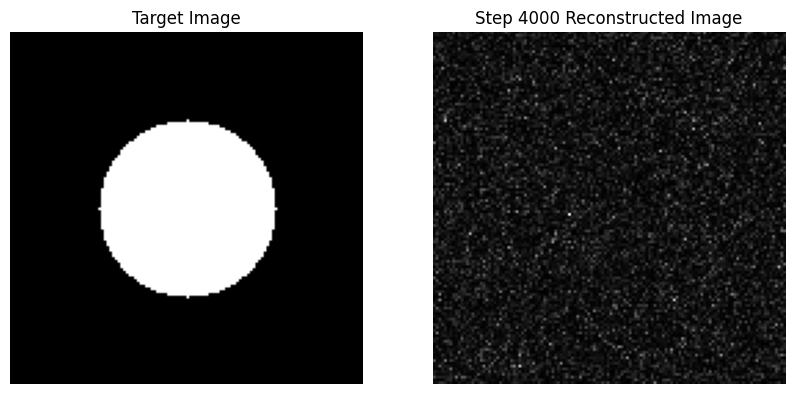

Step: 5000, Current Reward: -87.33


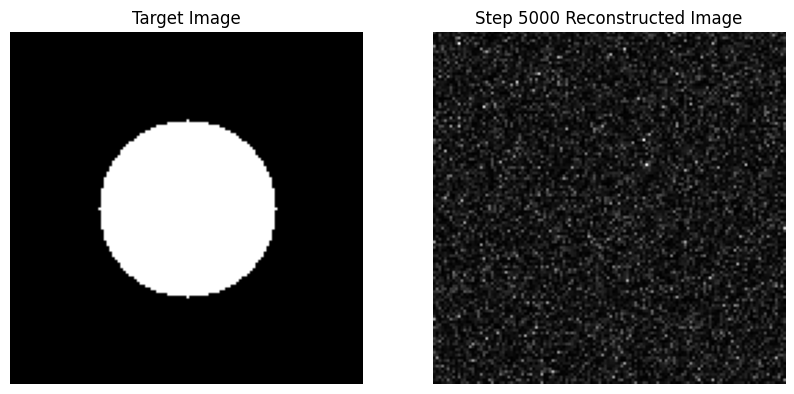

Step: 6000, Current Reward: -91.04


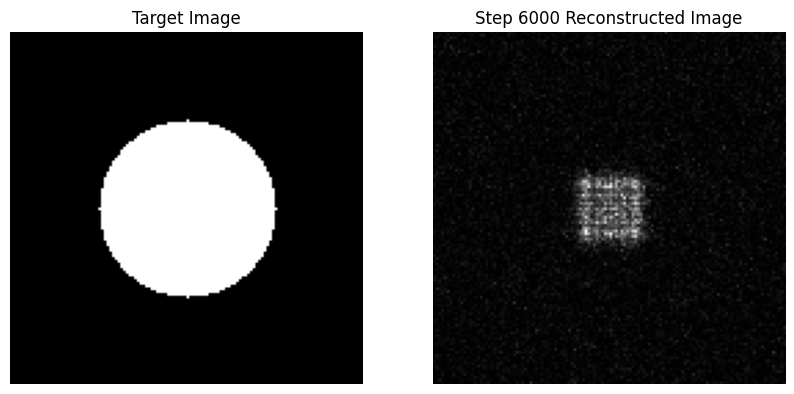

Step: 7000, Current Reward: -90.85


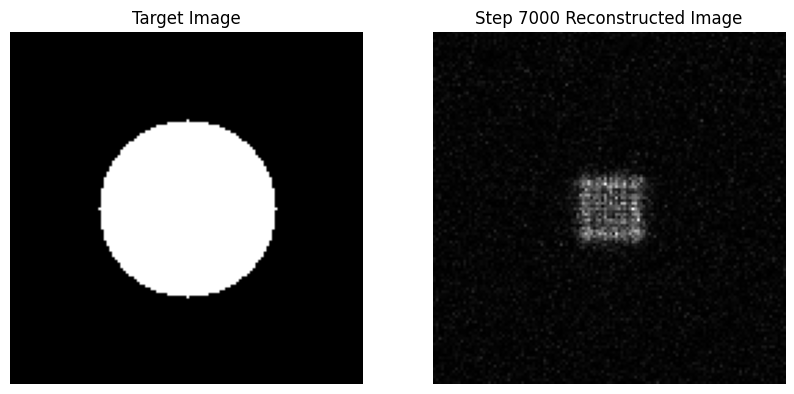

Step: 8000, Current Reward: -88.46


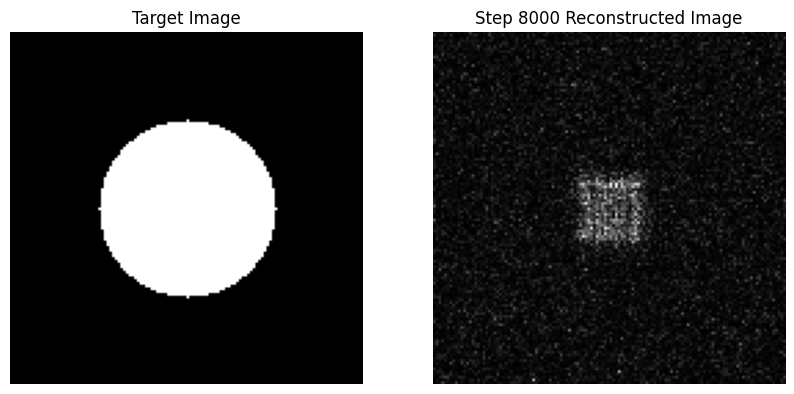

Step: 9000, Current Reward: -89.04


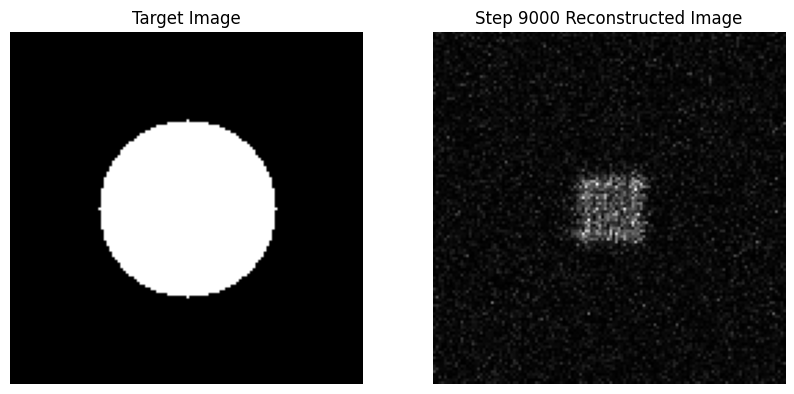

Step: 10000, Current Reward: -89.46


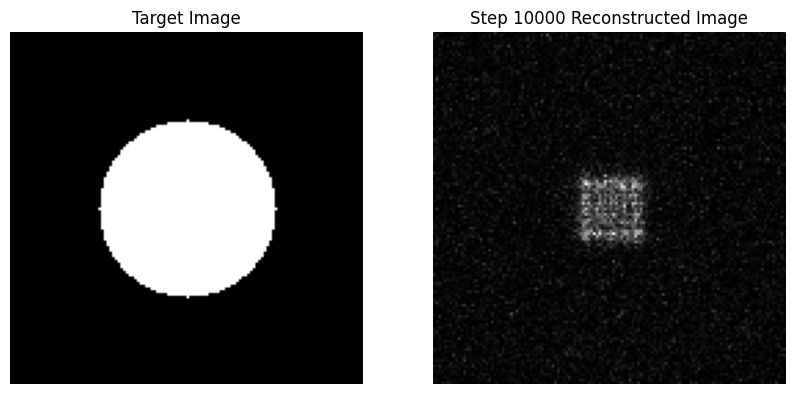

Step: 11000, Current Reward: -95.40


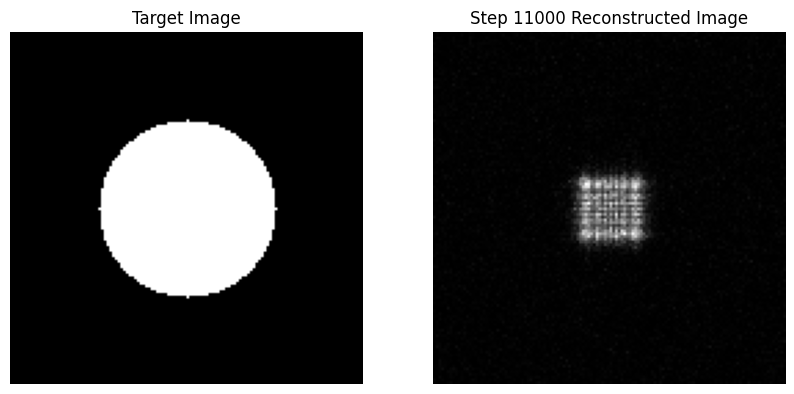

Step: 12000, Current Reward: -95.45


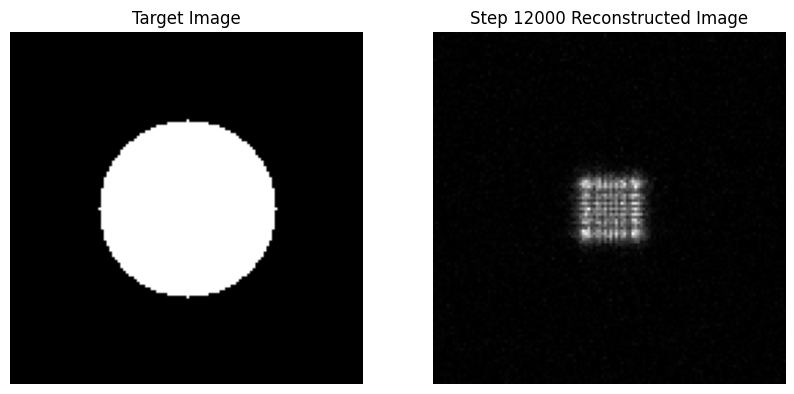

Step: 13000, Current Reward: -97.43


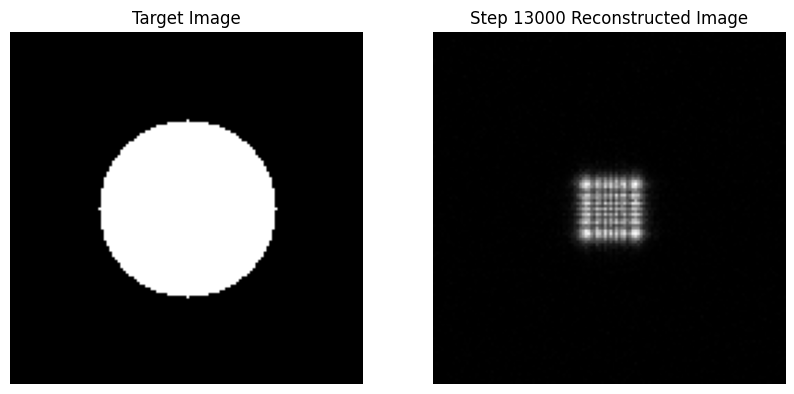

Step: 14000, Current Reward: -97.75


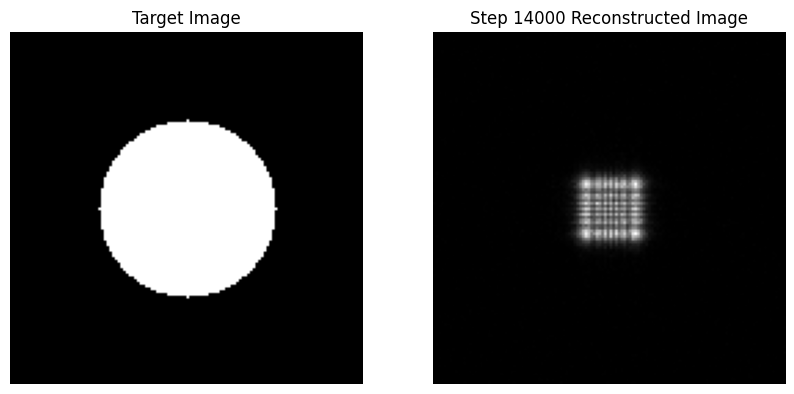

Step: 15000, Current Reward: -97.82


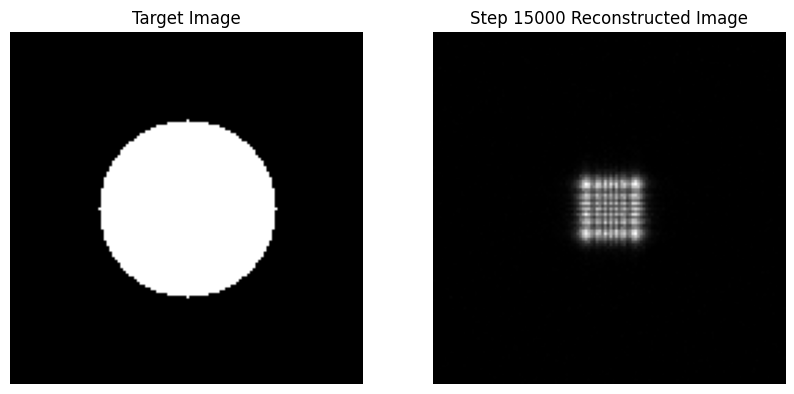

Step: 16000, Current Reward: -97.92


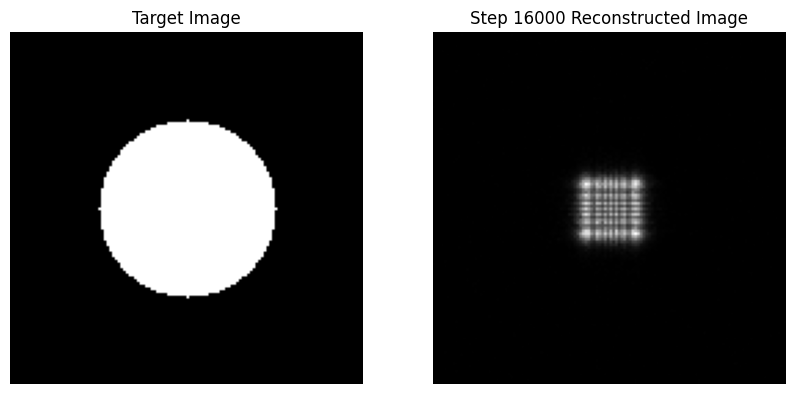

Step: 17000, Current Reward: -97.96


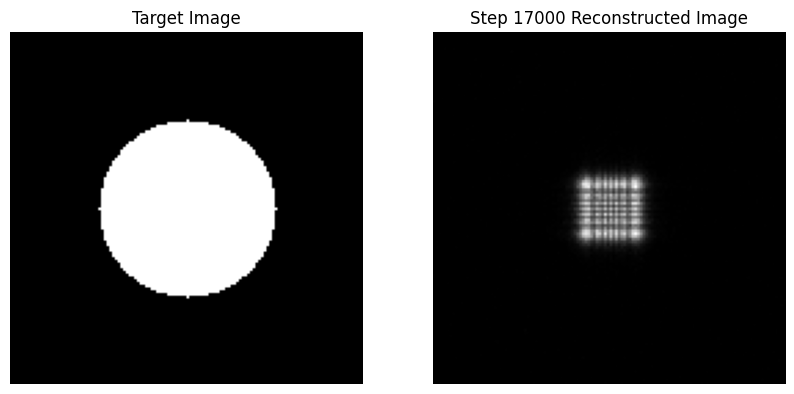

Step: 18000, Current Reward: -98.04


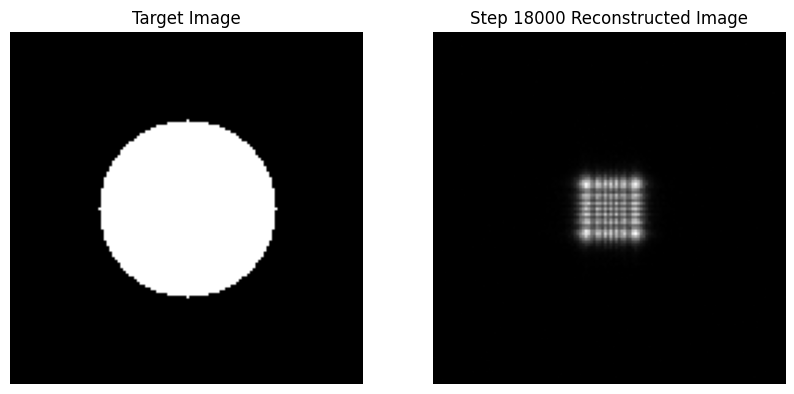

Step: 19000, Current Reward: -98.28


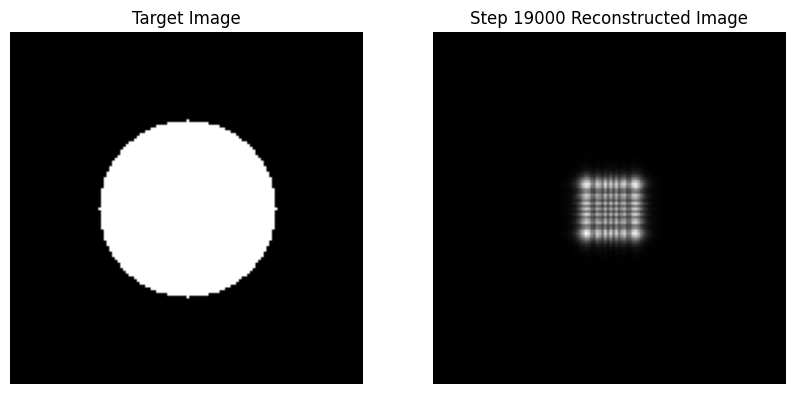

Step: 20000, Current Reward: -98.26


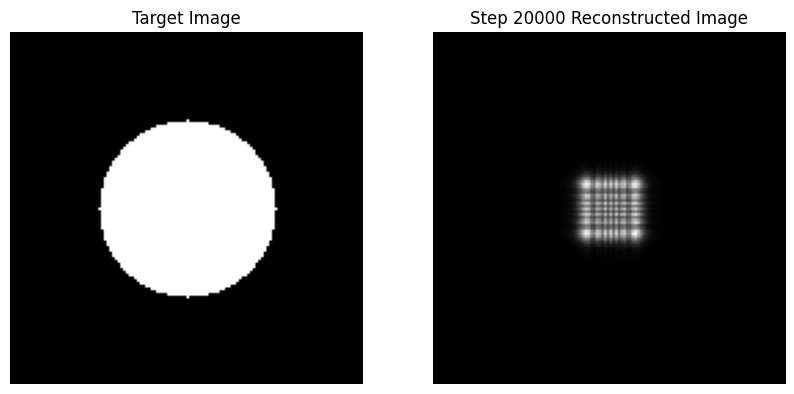

Step: 21000, Current Reward: -98.33


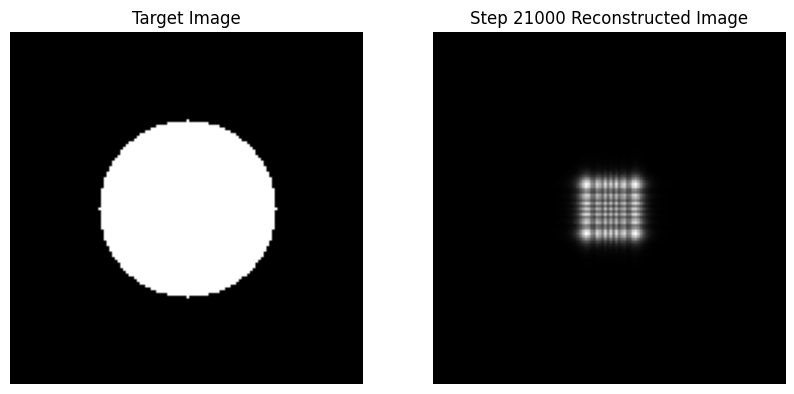

Step: 22000, Current Reward: -98.36


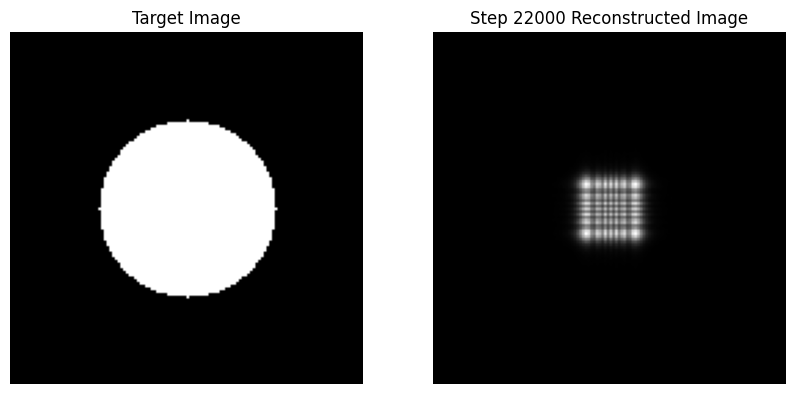

Step: 23000, Current Reward: -98.33


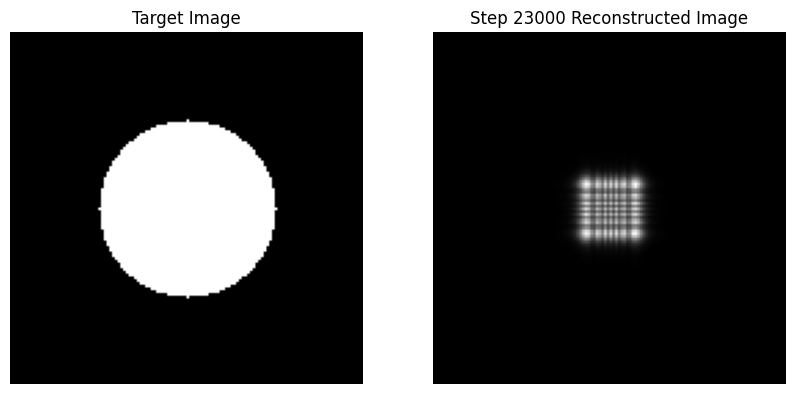

Step: 24000, Current Reward: -98.32


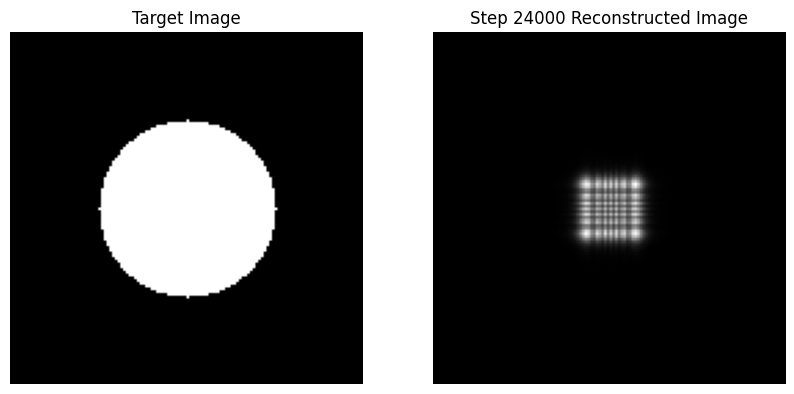

Step: 25000, Current Reward: -98.37


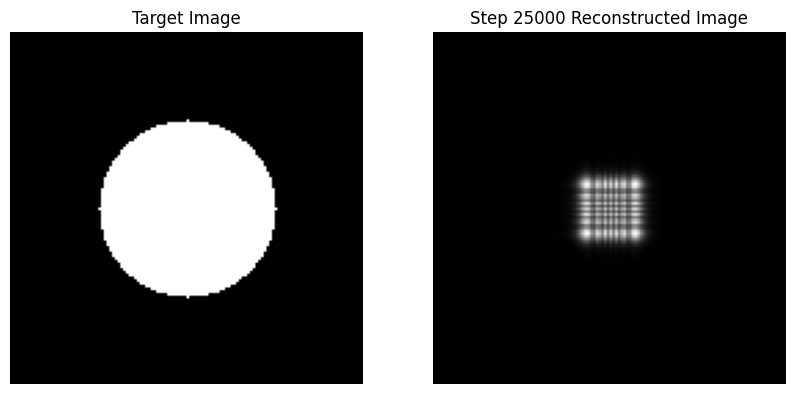

Step: 26000, Current Reward: -98.32


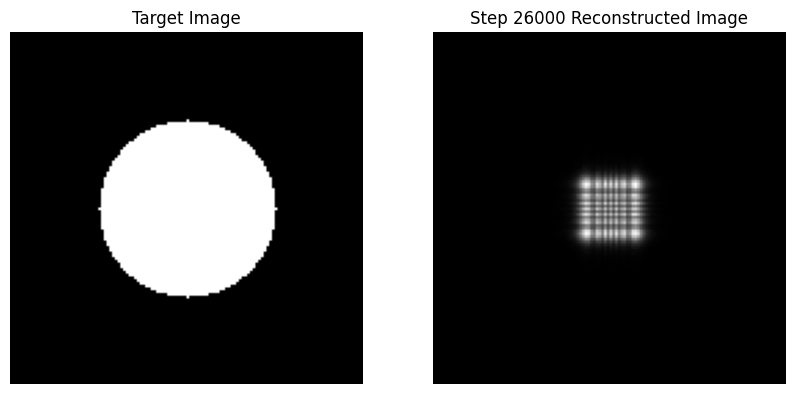

Step: 27000, Current Reward: -98.33


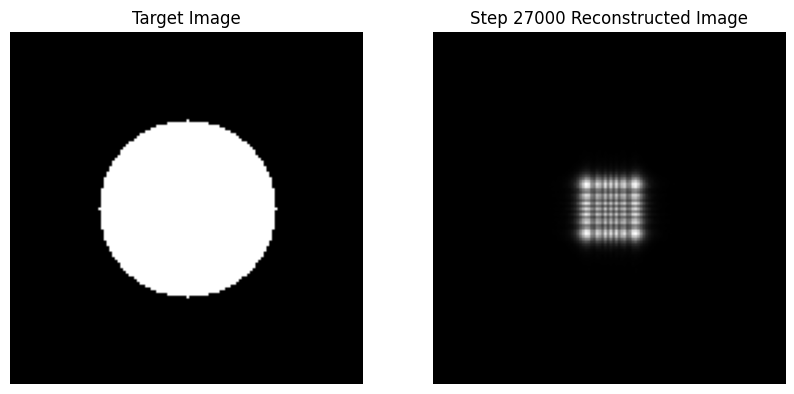

Step: 28000, Current Reward: -98.32


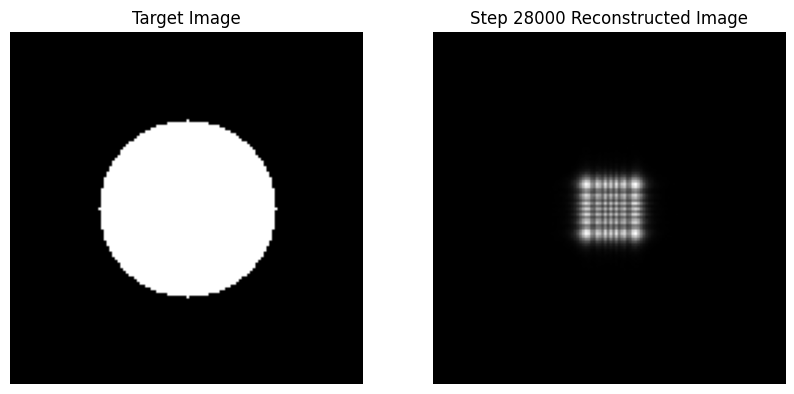

Step: 29000, Current Reward: -98.37


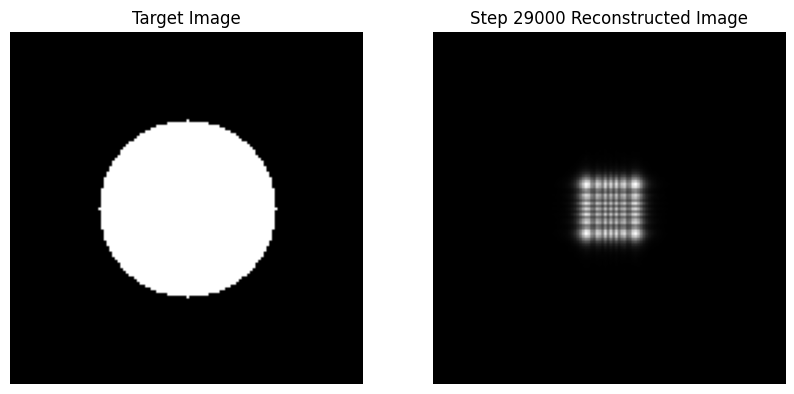

Step: 30000, Current Reward: -98.33


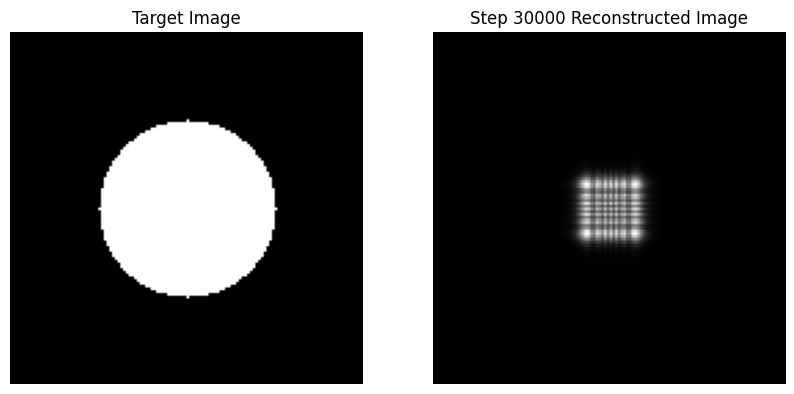

Step: 31000, Current Reward: -98.30


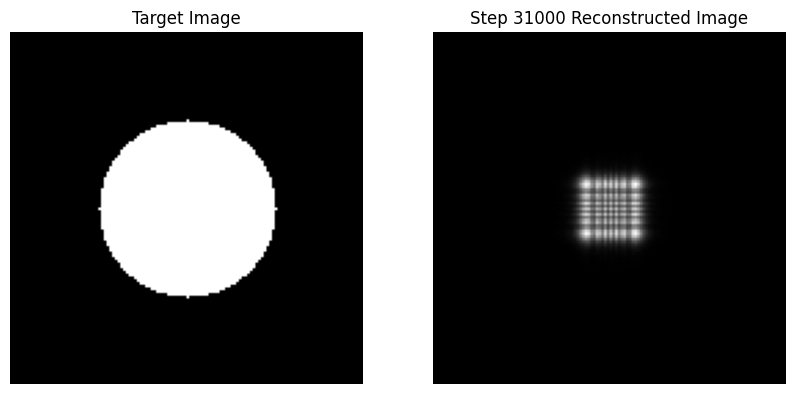

Step: 32000, Current Reward: -98.29


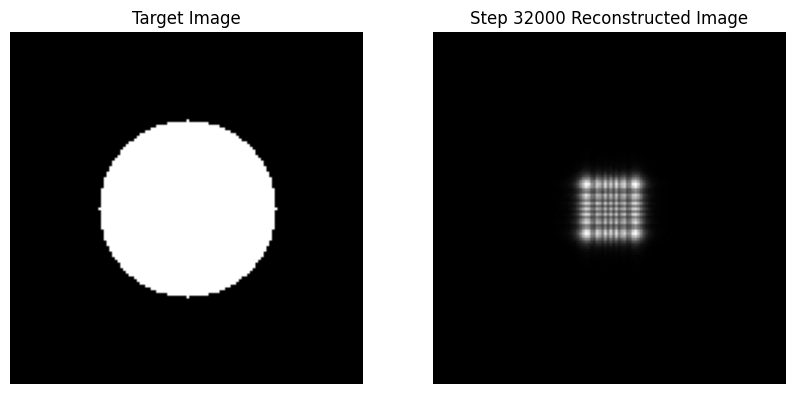

Step: 33000, Current Reward: -98.17


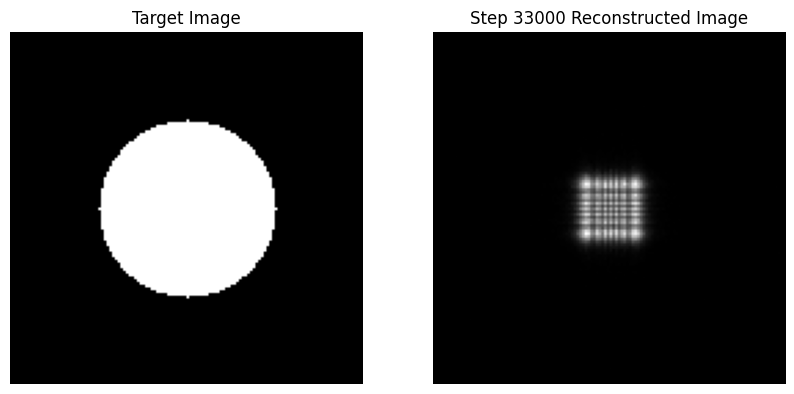

Step: 34000, Current Reward: -98.09


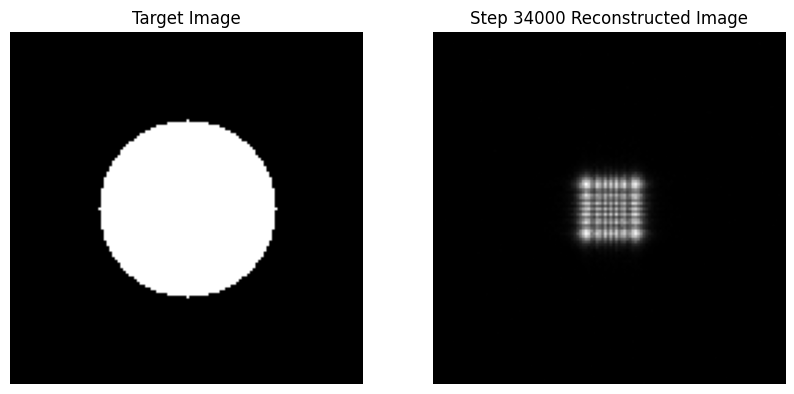

KeyboardInterrupt: 

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import cv2
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
from datetime import datetime


class CGHEnv(gym.Env):
    def __init__(self, target_image, grid_size):
        """
        CGH 환경 초기화
        :param target_image: 목표 이미지 (정규화된 흑백 이미지)
        :param grid_size: 위상 패턴의 격자 크기
        """
        super(CGHEnv, self).__init__()
        self.target_image = target_image
        self.grid_size = grid_size

        # 행동 및 관측 공간 정의
        self.action_space = spaces.Box(low=-np.pi, high=np.pi, shape=(grid_size, grid_size), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.pi, high=np.pi, shape=(grid_size, grid_size), dtype=np.float32)

        self.state = None

    def reset(self, seed=None, options=None):
        """
        환경 초기화
        """
        super().reset(seed=seed)
        np.random.seed(seed)
        self.state = np.random.uniform(-np.pi, np.pi, (self.grid_size, self.grid_size))
        info = {}
        return self.state, info

    def step(self, action):
        """
        환경의 한 스텝 진행
        """
        self.state = action  # 행동에 따라 위상 패턴을 업데이트
        reconstructed_image = self.generate_hologram(self.state)  # 홀로그램 생성

        # PSNR 계산
        mse = np.mean((self.target_image - reconstructed_image) ** 2)
        psnr = 10 * np.log10(1.0 / mse) if mse > 0 else 100
        reward = psnr  # 보상은 PSNR

        terminated = False  # CGH 문제는 종료 조건이 없음
        truncated = False
        info = {"PSNR": psnr}

        return self.state, reward, terminated, truncated, info

    def generate_hologram(self, phase_pattern):
        """
        프레넬 근사를 사용한 홀로그램 생성
        """
        wavelength = 633e-9  # 파장 (미터, 예: 633nm 레이저)
        distance = 0.1       # 물체-스크린 거리 (미터)
        pixel_size = 10e-6   # 픽셀 크기 (미터)

        # 격자 생성
        k = 2 * np.pi / wavelength  # 파수
        x = np.linspace(-self.grid_size // 2, self.grid_size // 2, self.grid_size) * pixel_size
        y = np.linspace(-self.grid_size // 2, self.grid_size // 2, self.grid_size) * pixel_size
        X, Y = np.meshgrid(x, y)

        # 프레넬 전달 함수
        fresnel_transfer_function = np.exp(1j * k / (2 * distance) * (X**2 + Y**2))

        # 복소수 위상 패턴 생성
        complex_field = np.exp(1j * phase_pattern)

        # FFT 기반 프레넬 근사
        hologram = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(complex_field * fresnel_transfer_function)))
        return np.abs(hologram) ** 2  # 강도 패턴 반환


def generate_simple_target(grid_size):
    """
    단순한 테스트용 타겟 이미지 생성
    """
    image = np.zeros((grid_size, grid_size), dtype=np.uint8)
    cv2.circle(image, (grid_size // 2, grid_size // 2), grid_size // 4, 255, -1)  # 단순한 원 생성
    image = image / 255.0  # 정규화
    return image


class CustomCallback(BaseCallback):
    """
    학습 중간에 진행 상황을 출력하는 콜백
    """
    def __init__(self, env, verbose=0):
        super(CustomCallback, self).__init__(verbose)
        self.env = env

    def _on_step(self) -> bool:
        if self.n_calls % 1000 == 0:  # 1000 스텝마다 출력
            print(f"Step: {self.n_calls}, Current Reward: {self.locals['rewards'][-1]:.2f}")

            # 중간 결과 이미지 출력
            reconstructed_image = self.env.generate_hologram(self.env.state)
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(self.env.target_image, cmap='gray')
            plt.title("Target Image")
            plt.axis("off")
            plt.subplot(1, 2, 2)
            plt.imshow(reconstructed_image, cmap='gray')
            plt.title(f"Step {self.n_calls} Reconstructed Image")
            plt.axis("off")
            plt.show()

        return True


def train_and_save_model(env, timesteps):
    """
    SAC 알고리즘으로 모델 학습 후 저장
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # 타임스탬프
    model_save_path = f"cgh_sac_model_{timestamp}.zip"

    callback = CustomCallback(env)
    model = SAC("MlpPolicy", env, buffer_size=200000, learning_starts=5000, verbose=1)  # 하이퍼파라미터 조정
    model.learn(total_timesteps=timesteps, callback=callback)
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")
    return model, model_save_path


def evaluate_and_save_images(env, model, steps):
    """
    학습된 모델 평가 및 재구성된 이미지 저장
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_image_path = f"reconstructed_image_{timestamp}.png"

    obs, _ = env.reset()
    for _ in range(steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)

    reconstructed_image = env.generate_hologram(obs)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(env.target_image, cmap='gray')
    plt.title("Target Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title("Reconstructed Hologram")
    plt.axis("off")
    plt.savefig(output_image_path)
    plt.show()
    print(f"Reconstructed image saved to {output_image_path}")


if __name__ == "__main__":
    # 환경 및 학습 설정
    grid_size = 128
    timesteps = 50000  # 학습 스텝 증가

    # 단순한 타겟 이미지 생성
    target_image = generate_simple_target(grid_size)

    # 타겟 이미지 시각화
    plt.figure()
    plt.imshow(target_image, cmap='gray')
    plt.title("Target Image")
    plt.axis('off')
    plt.show()

    # 강화학습 환경 생성
    env = CGHEnv(target_image, grid_size)
    vec_env = make_vec_env(lambda: env, n_envs=1)

    # 모델 학습 및 저장
    model, model_save_path = train_and_save_model(env, timesteps)

    # 평가 및 결과 저장
    evaluate_and_save_images(env, model, steps=100)
